# Preparation

In [2]:
# basic setup of the notebook
%pylab inline
from pprint import pprint # we use this to pretty print some stuff later

import numpy as np
import pandas as pd

from matplotlib.colors      import LogNorm
from matplotlib             import pyplot as plt
from matplotlib.collections import RegularPolyCollection

from iminuit import Minuit
from iminuit import minimize

# from scipy.optimize import minimize
from scipy.special     import expit
from scipy.stats       import chi2
from scipy.interpolate import make_interp_spline, BSpline

# Fancy fonts
# from matplotlib import rc
# rc('text', usetex=True)


Populating the interactive namespace from numpy and matplotlib


In [3]:
# defining constants
mec_dim       = 24  # dimension of matrix of rescaling
events_number = 5e6  # number of events in sample
cross_section = 1.19683e-39  # calculated cross section in .txt file
alpha         = 0.2 # parameter of smoothness

delta_pT           = np.array([75, 75, 100, 75, 75, 75, 75, 150, 150, 150, 250, 250, 1000])
delta_pT_plot      = np.array([75, 75, 100, 75, 75, 75, 75, 150, 150, 150, 250, 250, 1000, 0])
delta_pL           = np.array([500, 500, 500, 500, 500, 500, 500, 1000, 2000, 2000, 5000, 5000])
pT                 = np.array([75, 150, 250, 325, 400, 475, 550, 700, 850, 1000, 1250, 1500, 2500])
pT_plot            = np.array([75, 150, 250, 325, 400, 475, 550, 700, 850, 1000, 1250, 1500, 2500, 3000])
pL                 = np.array([1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 6000, 8000, 10000, 15000, 20000])
bins_width_vanilla = np.kron(delta_pT, delta_pL)
bins_width         = np.outer(bins_width_vanilla,  np.ones(mec_dim**2))

# print(bins_width)

In [4]:
# loading files
matrix_vanilla      = np.fromfile("../data/matrix_LFG.dat",                sep=" ")  # distribution of MEC events in bins 
cross_nuwro         = np.fromfile("../data/cros_total_nuwro_LFG.dat",      sep=" ")  # cross section of nuwro (w-o MEC)
cross_daniel        = np.fromfile("../data/cros_total_daniel.dat",         sep=" ")  # cross section of MINERvA
covariance_vanilla  = np.fromfile("../data/daniel_covariance_vanilla.dat", sep=" ")  # covariance matrix
cross_error_vanilla = np.fromfile("../data/cros_error_daniel.dat",         sep=" ")  # error bars

In [5]:
# modifying files
matrix_unnormalized    = np.reshape(matrix_vanilla,(156, mec_dim**2))  # reshaping MEC matrix
matrix                 = matrix_unnormalized * cross_section * 1e6 * 12 / 13 / bins_width / events_number  # normalizing matrix

covariance_noninverted = np.reshape(covariance_vanilla, (156,156))  # reshaping covarince matrix
covariance             = pinv(covariance_noninverted)  # pseudo-inverse covariance matrix (used later); inverse doesnt exist

cross_error            = np.where(cross_error_vanilla==0, 1, cross_error_vanilla)  # removing zeros from error bars

# rotation of results due to covariance matrix's look 
cross_daniel_cov       = np.reshape(cross_daniel,(12,13)).transpose().flatten()  
cross_nuwro_cov        = np.reshape(cross_nuwro,(12,13)).transpose().flatten()

# Definitions of useful functions

In [6]:
def mysigmo(x, trans=0): # my modified sigmoid
    return 100*expit(x*200-trans)

#################################
# bounds and constrains
tmp = []
for i in range(0,24):  # fixing over diagonal elements
    tmp += [1,1] * i + [0.1, None] * (24-i)
    
bnd = np.reshape(tmp,(576,2))  # bounds - no zero in order to avoid division by it

##################################

upper = []
for i in range(24):
    for j in range(0, i):
        upper += [24*i + j]  # elements' indexes over diagonal 

lower = []
for i in range(24):
    for j in range(i, 24):
        lower += [24*i + j]  # elements' indexes below diagonal 

# d - diagonal_line 
# r - right_line
# b - bottom line
# i - inner
# . - both 
#
#     ---------
#     |      .|
#     |    dir|
#     |  diiir|
#     |.bbbbb.|
#     ---------

bottom_line    = range(24)
right_line     = range(23, 24 ** 2, 24)
diagonal_line  = [24*i + i for i in range(24)]
inner          = [x for x in lower if x not in bottom_line and x not in right_line and x not in diagonal_line]


def punishment(rescale): 
    
    pun = 0 # punishment

    for i in bottom_line[1:-1]:  # for bottom side of matrix
        pun += mysigmo(-rescale[i] / max( \
                rescale[i + 1], \
                rescale[i + 24],\
                rescale[i - 1]) + (1 - alpha))
        pun += mysigmo(rescale[i] / min( \
                rescale[i + 1], \
                rescale[i + 24],\
                rescale[i - 1]) - 1/(1 - alpha))

    for i in right_line[1:-1]:  # for right side of matrix
        pun += mysigmo(-rescale[i] / max( \
                rescale[i + 24], \
                rescale[i - 1],\
                rescale[i - 24]) + (1 - alpha))
        pun += mysigmo(rescale[i] / min( \
                rescale[i + 24], \
                rescale[i - 1],\
                rescale[i - 24]) - 1/(1 - alpha))

    for i in diagonal_line[1:-1]:  # for diagonal side of matrix
        pun += mysigmo(-rescale[i] / max( \
                rescale[i + 1], \
                rescale[i - 24]) + (1 - alpha))
        pun += mysigmo(rescale[i] / min( \
                rescale[i + 1], \
                rescale[i - 24]) - 1/(1 - alpha))

    for i in inner[0:-1]:  # for the rest 
        pun +=  mysigmo(-rescale[i] / max( \
                rescale[i + 1],\
                rescale[i - 1],\
                rescale[i + 24],\
                rescale[i - 24]) + (1 - alpha))
        pun += mysigmo(rescale[i] / min( \
                rescale[i + 1],\
                rescale[i - 1],\
                rescale[i + 24],\
                rescale[i - 24]) - 1/(1 - alpha))
        
    return pun

In [7]:
# preparation - useful function
def chi2_cov(rescaling, pun=True):  # definition of chi^2 with covariance
    mec = np.reshape(np.matmul(matrix, rescaling),(12,13)).flatten()  # rescaled MEC
        
    tmp = (cross_daniel_cov - cross_nuwro_cov - mec)
    if pun==True:
        return (np.matmul(np.matmul(tmp,covariance), tmp) + punishment(rescaling))  # chi^2 = tmp.cov.tmp
    else:
        return (np.matmul(np.matmul(tmp,covariance), tmp))
    
#######################################

def starting_matrix(x, ran=True):  # starting matrix - 1 above diagonal, x below diagonal
    tmp = []
    
    if ran == True:
        for i in range(0,24):
            tmp += [1] * i + [x + 0.1*random.random() for a in range(24-i)] # with random fluctuation
    else:
        for i in range(0,24):
            tmp += [1] * i + [x] * (24 - i) # without random fluctuation
        
    return tmp

#########################################

def plot_matrix(x, chi2, method, success):  # drawing matrix and saving it to .pdf file 
    rescale = np.reshape(x,(24,24))

    for i in range(24):
        for j in range(i + 1, 24):
            rescale[j][i] = None

    fig = plt.figure(num=1, figsize=(1, 1), dpi=1, facecolor='w', edgecolor='k')
    fig, ax = plt.subplots()

    for (j,i),label in np.ndenumerate(rescale):
        if (label>0):
            ax.text(50*i+25,50*j+25,"{0:.1f}".format(label),ha='center',va='center',fontsize=3,color="black",weight='bold')
        else:
            ax.text(50*i+25,50*j+25," ",ha='center',va='center',fontsize=3,color="white",weight='bold')

    im = ax.imshow(rescale, origin="lower",extent=(1,1200,1,1200))
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(" ", rotation=-90, va="bottom")
    
    ax.set_title('$\\chi^2$ =' + str('%.2f' % chi2) + \
             ', with constrains $\\alpha = $' + str(alpha) + \
             ",\n method - " + str(method) + \
             ", success - " + str(success), fontsize=10)
    
    savetxt("matrices/matrix_" + str('%.2f' % chi2) + "_" + str(method) + ".dat", rescale)
    fig.savefig("plots/matrix_" + str('%.2f' % chi2) + "_" + str(method) + ".pdf",dpi=300, bbox_inches='tight', pad_inches=0, quality=95)

    plt.show()

In [8]:
# plot_results(x=np.ones(mec_dim**2)/2,title="MINUIT2", save=True)

# migrad()

In [9]:
# test_1 - chi^2 w-o covariance
# chi2 = (((cross_daniel - cross_nuwro - mec)/cross_error)**2).sum()
# print(chi2)

# print(chi2_cov(np.ones(576)))

In [10]:
# # old method - using Minuit interface -> it easier to use minimize fuction than migrad
# non_negative = np.reshape((0, None) * mec_dim**2, (mec_dim**2,2))  # every element should not be negative

# triangular = []
# for i in range(0,24):  # fixing over diagonal elements
#     triangular += [True] * i + [False] * (24-i)
    
# def m(x):  # m for different starting parameter
#     return Minuit.from_array_func(chi2_cov, 
#                                   starting_matrix(x), 
#                                   error=0.1, 
#                                   errordef=1, 
#                                   limit=non_negative, 
#                                   fix=triangular,
#                                   use_array_call=True)

In [11]:
# # ploting one solution -- old method
# tmp = m(1)
# tmp.migrad()
# plot_matrix(tmp.np_values(), tmp.fval, "migrad", str(tmp.migrad_ok()))

In [12]:
non_negative = np.reshape((0.1, None) * mec_dim**2, (mec_dim**2,2))  # every element should not be negative

triangular = []
for i in range(0,24):  # fixing over diagonal elements
    triangular += [True] * i + [False] * (24-i)

In [ ]:
m = Minuit.from_array_func(chi2_cov, 
                      starting_matrix(1),
                      error=0.1, 
                      errordef=1, 
                      limit=non_negative, 
                      fix=triangular,
                      use_array_call=True)

m.migrad(ncall=1000000)
plot_matrix(m.np_values(), chi2_cov(m.np_values(),False), "migrad", str(m.migrad_ok()))

for i in range(100):
    m = Minuit.from_array_func(chi2_cov, 
                          m.np_values(),
                          error=0.1, 
                          errordef=1, 
                          limit=non_negative, 
                          fix=triangular,
                          use_array_call=True)

    m.migrad(ncall=1000000)
    plot_matrix(m.np_values(), chi2_cov(m.np_values(),False), "migrad", str(m.migrad_ok()))

In [1]:
ress = np.array(loadtxt("../Mathematica/results/chi2ValuesFinal/chi2cov_324.313_maxIter_100_continuous_0.4_InteriorPoint.dat")).flatten()

NameError: name 'np' is not defined

In [ ]:
# # checking Minuit -- easier method

# res = minimize(chi2_cov, 
#                starting_matrix(1), 
#                bounds=bnd,
#                options={"maxfev":10000000})

# plot_matrix(res["x"], chi2_cov(res["x"], False) , "migrad", res["success"])

# for i in range(4):
#     res = minimize(chi2_cov, 
#                    res["x"], 
#                    bounds=bnd,
#                    options={"maxfev":10000000})

#     plot_matrix(res["x"], chi2_cov(res["x"], False) , "migrad", res["success"])

In [ ]:
# # how does the result change with respect to starting matrix
# chi2_of_starting_param = []
# starting_param = []

# for i in numpy.arange(0, 1, 0.1):
#     tmp = m(i)
#     tmp.migrad()
#     chi2_of_starting_param += [tmp.fval]
#     starting_param += [i]
    
# xlabel("param of starting matrix")
# ylabel("$\\chi^2$")
# plot(starting_param, chi2_of_starting_param,".")
# # savefig("/home/michaszko/Desktop/lol.pdf")

In [ ]:
# # how does the result osccilate 
# chi2_of_starting_param = []
# starting_param = []

# for i in range(10):
#     tmp = m(0.1)
#     tmp.migrad()
#     chi2_of_starting_param += [tmp.fval]
#     starting_param += [i]
    
# xlabel("param of starting matrix")
# ylabel("$\\chi^2$")
# plot(starting_param, chi2_of_starting_param,".")
# # savefig("/home/michaszko/Desktop/lol.pdf")

# minimize() 
### with scipy

# Plotting matrices

In [170]:
def plot_squares(data, ax=None, name="wq", **kwargs): # function for plotting matrices with squares
    
    factor = 5
    
    # search for maximal element (normalization) in the array
    maxi = max(map(max, data))
    mini = min(map(min, data))    
    
    M = np.array(data**2)*factor
    M[M > 80] = 80
#     M[M == 0]  = factor
    
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    if ax is None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'aspect':'equal'})
        ax.set_xlim(-0.5, M.shape[1] - 0.5)
        ax.set_ylim(-0.5, M.shape[0] - 0.5)
        
    # xy locations of each square center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T
    
#     #     eliminate elements above diagonal
#     M[M == 1] = 0

    # set width for circles according to the value in the bin and normalize to maxi
#     w = log(M.ravel()) / log(maxi + 1) # log version
    w = (M.ravel())       # nonlog version

#     ec = EllipseCollection(widths=w, heights=w, angles=90, units='x', offsets=xy,
#                            transOffset=ax.transData, array=M.ravel(), **kwargs)

    ec = RegularPolyCollection(4, sizes=w, rotation=math.pi/4, facecolor='black', 
                               edgecolor='black', offsets=xy, transOffset=ax.transData, norm=10)
    
    ax.add_collection(ec)
    
    ax.set_xticks(np.arange(0,28,4))
    ax.set_xticklabels(np.arange(0,1201,200))
    ax.set_yticks(np.arange(0,28,4))
    ax.set_yticklabels(np.arange(0,1201,200))
    
    xlabel("q [MeV]")
    ylabel("$\omega$ [MeV]")
    title("Rescaling matrix")
    legend(("value 1",), loc=2, markerscale=0.18*sqrt(factor))
        
    plt.savefig("plots/" + name + ".pdf", dpi=300, bbox_inches='tight', pad_inches=0, quality=95)
    
    return ec

In [171]:
# Loading matrix from the file

# matrix = np.array(loadtxt("results/chi2ValuesFinal/chi2cov_324.313_maxIter_100_continuous_0.4_InteriorPoint.dat")).flatten()
the_matrix = np.array(loadtxt("../Mathematica/results/chi2ValuesFinal/scaling_matrix.dat")).flatten()
the_matrix = the_matrix.reshape(24,24)

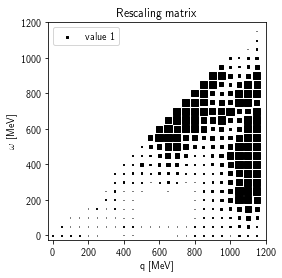

In [172]:
plot_squares(the_matrix)

# Plotting results

In [13]:
def plot_results(x=np.ones(mec_dim**2), save=True):
    mec = np.reshape(np.matmul(matrix, x),(13,12)).transpose().flatten()  # MEC cross section
    mec_org = np.reshape(np.matmul(matrix, np.ones(mec_dim**2)),(13,12)).transpose().flatten()  # MEC cross section

    for i in range(12):
        plt.figure(i)
        
        kosz = i*13
        tmp1 = np.append(cross_nuwro[kosz:kosz+13],cross_nuwro[kosz+12])
        tmp2 = np.append(mec[kosz:kosz+13],mec[kosz+12])
        tmp3 = np.append(mec_org[kosz:kosz+13],mec_org[kosz+12])
        
        plt.step(pT_plot-delta_pT_plot,
                 tmp1+tmp3,
                 linestyle='--',
                 linewidth=0.7,
                 color='black',
                 where="post",
                 label="Vanilla NuWro")
        plt.step(pT_plot-delta_pT_plot,
                 tmp1+tmp2,
                 linestyle=':',
                 linewidth=0.7,
                 color='black',
                 where="post",
                 label="Scaled NuWro")
        plt.errorbar(pT-delta_pT/2, 
                     cross_daniel[kosz:kosz+13], 
                     yerr=cross_error_vanilla[kosz:kosz+13], 
                     xerr=0, 
                     fmt="+",
                     linewidth=1,
                     color='black',
                     label="MINER$\\nu$A")
        
        plt.title(str(pL[i]) + "$ < p_L [MeV] < $" + str(pL[i+1]))
        
        leg = plt.legend()
        
        xlabel("$p_T$ [MeV]")
        ylabel("$\\sigma$ [cm$^2$ \\ GeV$^2$ \\ nucleon]")
        
#         xlim(0, None)
#         ylim(0, None)
        
        if save:
            plt.savefig("plots/" + "MINERVA" + "_matrix_" + str(i) + ".pdf")

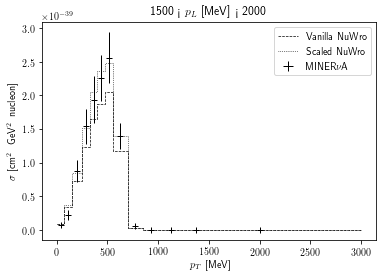

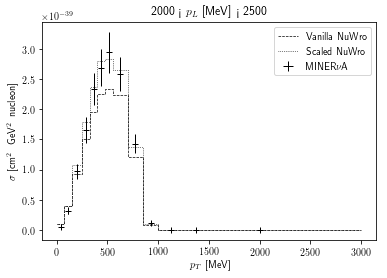

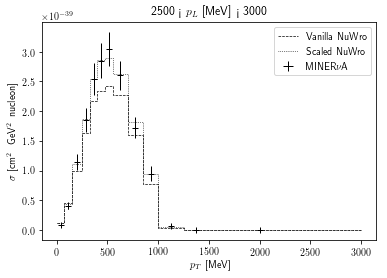

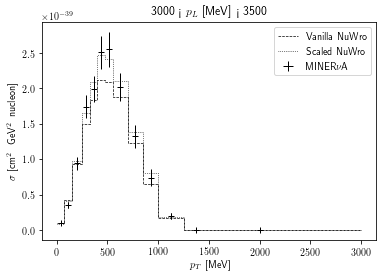

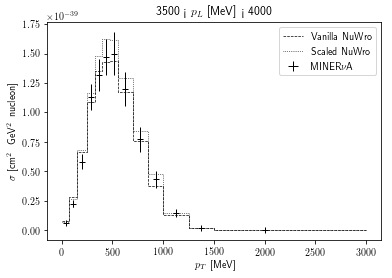

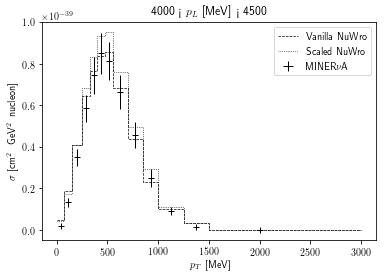

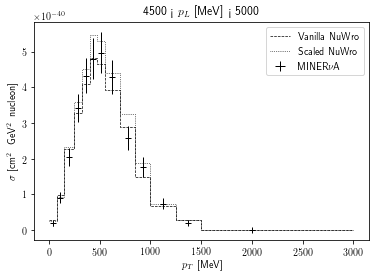

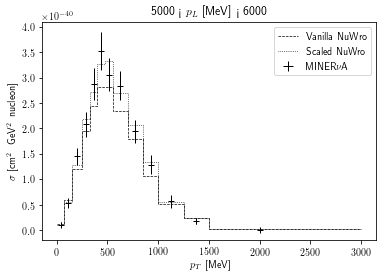

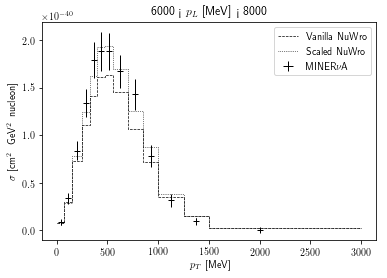

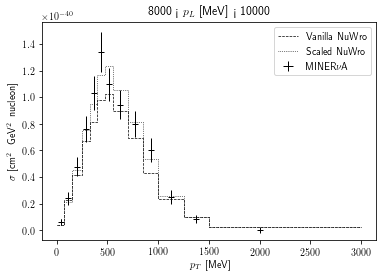

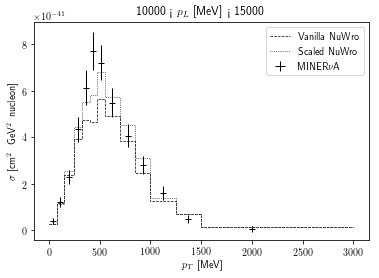

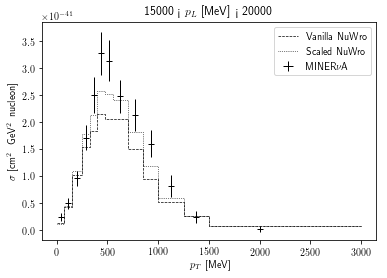

In [14]:
plot_results(x=(the_matrix.flatten()).transpose(), save=1)

# Plotting charts

In [146]:
xaxis = np.array([250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000])

numu0 = np.array([4.71703e-41, 3.47758e-40, 7.72614e-40, 1.07412e-39, 1.16272e-39, 1.18186e-39, 1.19262e-39, 1.19666e-39, 1.20368e-39, 
1.20799e-39, 1.21247e-39, 1.21918e-39, 1.21916e-39, 1.2239e-39, 1.22628e-39, 1.23059e-39, 1.23121e-39, 1.23783e-39, 
1.23227e-39, 1.23688e-39])

numu1 = np.array([1.19771e-41, 1.41624e-40, 7.63732e-40, 1.67995e-39, 1.92049e-39, 1.96045e-39, 1.99521e-39, 2.02054e-39, 2.04153e-39, 2.04591e-39,
2.06397e-39, 2.0782e-39, 2.0834e-39, 2.09216e-39, 2.09975e-39, 2.10598e-39, 2.10863e-39, 2.11396e-39, 2.12236e-39, 2.11707e-39])

anumu0 = np.array([1.8147e-41, 1.09496e-40, 2.39121e-40, 3.88543e-40, 5.12156e-40, 6.08378e-40, 6.88277e-40, 7.55304e-40, 8.01704e-40, 8.3843e-40,
8.80138e-40, 9.1397e-40, 9.40355e-40, 9.58258e-40, 9.82933e-40, 9.97001e-40, 1.01683e-39, 1.02917e-39, 1.038e-39, 1.05201e-39])
 
anumu1 = np.array([4.62948e-42, 4.02412e-41, 1.55526e-40, 4.09756e-40, 6.50684e-40, 8.45083e-40, 9.97112e-40, 1.12102e-39, 1.21937e-39, 1.31257e-39,
1.38268e-39, 1.44784e-39, 1.50097e-39, 1.54922e-39, 1.58678e-39, 1.62593e-39, 1.659e-39, 1.68701e-39, 1.71024e-39, 1.74051e-39])

xnew = np.linspace(xaxis.min(), xaxis.max(),300)
xnew_1 = np.linspace(300, xaxis.max(),300)

spl_1 = make_interp_spline(xaxis, numu0, k=3)
power_smooth_1 = spl_1(xnew)

spl_2 = make_interp_spline(xaxis, numu1, k=3)
power_smooth_2 = spl_2(xnew_1)

spl_3 = make_interp_spline(xaxis, anumu0, k=3)
power_smooth_3 = spl_3(xnew)

spl_4 = make_interp_spline(xaxis, anumu1, k=3)
power_smooth_4 = spl_4(xnew)

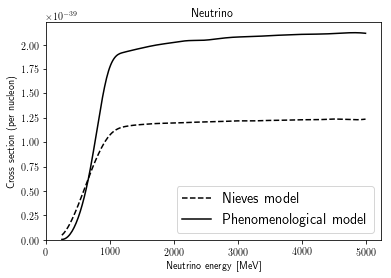

In [147]:
plt.plot(xnew,power_smooth_1, color="black", linestyle="dashed")
plt.plot(xnew,power_smooth_2, color="black", linestyle="default")

plt.title("Neutrino")
plt.xlabel("Neutrino energy [MeV]")
plt.ylabel("Cross section (per nucleon)")
plt.xlim(0)
plt.ylim(0)
plt.legend(('Nieves model', 'Phenomenological model'),loc=4, fontsize='x-large')

plt.savefig("plots/" + "neutrino" + ".pdf", dpi=300, bbox_inches='tight', pad_inches=0, quality=95)

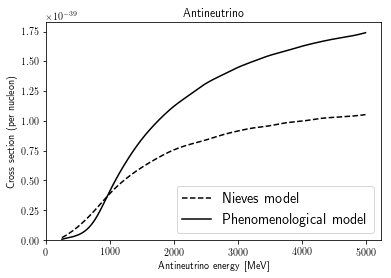

In [148]:
plt.plot(xnew,power_smooth_3, color="black", linestyle="dashed")
plt.plot(xnew,power_smooth_4, color="black", linestyle="default")

plt.title("Antineutrino")
plt.xlabel("Antineutrino energy [MeV]")
plt.ylabel("Cross section (per nucleon)")
plt.xlim(0)
plt.ylim(0)
plt.legend(('Nieves model', 'Phenomenological model'),loc=4, fontsize='x-large')

plt.savefig("plots/" + "antineutrino" + ".pdf", dpi=300, bbox_inches='tight', pad_inches=0, quality=95)

# Last task

In [5]:
import pickle
with open('data/shape_matrix.pkl', 'rb') as f:
    shape_matrix = pickle.load(f)
    
covariance_noninverted_short = covariance_noninverted*1e80
shape_matrix_short = shape_matrix*1e80
cross_daniel_short = np.reshape(np.transpose(np.reshape(cross_daniel,(12,13))),(1,156))*1e40
cross_daniel_good = np.reshape(np.transpose(np.reshape(cross_daniel,(12,13))),(1,156))[0]

for i in np.flip(np.where(cross_daniel_good==0)[0],axis=0):
    shape_matrix_short = np.delete(shape_matrix_short, (i), axis=0)
    shape_matrix_short = np.delete(shape_matrix_short, (i), axis=1)
    covariance_noninverted_short = np.delete(covariance_noninverted_short, (i), axis=0)
    covariance_noninverted_short = np.delete(covariance_noninverted_short, (i), axis=1)
    cross_daniel_short = np.delete(cross_daniel_short, i)
    
shape_matrix_short_inv = pinv(shape_matrix_short)
shape_matrix_inv = pinv(shape_matrix)

savetxt("../data/daniel_covariance_short.dat", covariance_noninverted_short)
savetxt("../data/cross_daniel_short.dat", cross_daniel_short)
savetxt("../data/shape_matrix_short_inv.dat", shape_matrix_short_inv)

In [6]:
sample = 10000
df = 156
zeros = len(np.where(cross_daniel_good==0)[0])
eff_df = df-zeros-1

random_vector = np.random.multivariate_normal(cross_daniel_good*1e40, covariance_noninverted*1e80, sample)
chi2_vector = np.random.chisquare(eff_df,sample)
other_vector = np.random.poisson(eff_df,size=sample)
random_vector_norm = random_vector/np.resize(np.sum(random_vector,axis=1),(sample,1))*np.sum(cross_daniel_good*1e40)

diff = (cross_daniel_good*1e40 - random_vector_norm)
result = np.diag(np.matmul(np.matmul(diff,shape_matrix_inv*1e-80),np.transpose(diff)))

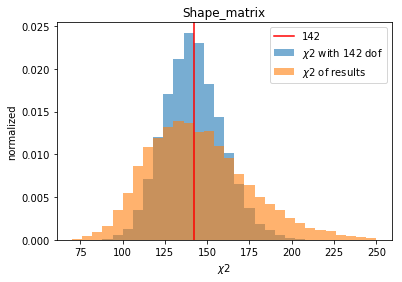

In [11]:
fig, ax = plt.subplots(1, 1)

# x = np.linspace(chi2.ppf(0.0001, eff_df), chi2.ppf(0.9999, eff_df), eff_df)
# ax.plot(x, chi2.pdf(x, eff_df),'m-', lw=3, alpha=0.6, label="$\chi2$ with " + str(eff_df) + " dof")
# ax.plot(x, chi2.pdf(x, df1),'g-', lw=5, alpha=0.6, label="$\chi2$ with " + str(df1) + " dof")

weights = np.ones_like(result)/len(result)

range1, range2, bins, density = (70, 250, 30, 1)

# ax.hist(other_vector, histtype="stepfilled", density=density, weights=weights,
#         label="poisson with " + str(df-zeros-1) + " dof", range=(range1, range2), bins=bins, alpha=0.6)

ax.hist(chi2_vector, histtype="stepfilled", density=density, weights=weights,
        label="$\chi2$ with " + str(df-zeros-1) + " dof", range=(range1, range2), bins=bins, alpha=0.6)

ax.hist(result, histtype="stepfilled", density=density, weights=weights,
        label="$\chi2$ of results", range=(range1, range2), bins=bins, alpha=0.6)

ax.axvline(df-zeros-1, color='r', label=str(df-zeros-1))

xlabel("$\chi$2")
ylabel("normalized")
title("Shape_matrix")
ax.legend()


# fig.savefig("shape_matrix_norm_chi2.pdf", dpi=70, bbox_inches='tight', pad_inches=0, quality=95)